<a href="https://colab.research.google.com/github/Chetan-Sagathiya/predicting-share-price-using-stacked-LSTM/blob/master/share_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
data = pdr.get_data_tiingo('TSLA', api_key="cf93b77051eb2461710d7e9dd98b73959036c237")

In [72]:
data.tail()

close    high  ...  divCash  splitFactor
symbol date                                       ...                      
TSLA   2021-05-24 00:00:00+00:00  606.44  614.48  ...      0.0          1.0
       2021-05-25 00:00:00+00:00  604.69  613.99  ...      0.0          1.0
       2021-05-26 00:00:00+00:00  619.13  626.17  ...      0.0          1.0
       2021-05-27 00:00:00+00:00  630.85  631.13  ...      0.0          1.0
       2021-05-28 00:00:00+00:00  625.22  635.59  ...      0.0          1.0

[5 rows x 12 columns]

In [74]:
data.to_csv("tesla.csv")

In [75]:
data = pd.read_csv("tesla.csv")
data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,TSLA,2016-06-01 00:00:00+00:00,219.56,222.400,216.89,221.48,2982695,43.912,44.4800,43.378,44.296,14913475,0.0,1.0
1,TSLA,2016-06-02 00:00:00+00:00,218.96,219.909,217.11,219.59,2032832,43.792,43.9818,43.422,43.918,10164160,0.0,1.0
2,TSLA,2016-06-03 00:00:00+00:00,218.99,221.940,218.01,220.00,2228970,43.798,44.3880,43.602,44.000,11144850,0.0,1.0
3,TSLA,2016-06-06 00:00:00+00:00,220.68,220.900,215.45,218.00,2249508,44.136,44.1800,43.090,43.600,11247540,0.0,1.0
4,TSLA,2016-06-07 00:00:00+00:00,232.34,234.440,221.52,222.24,6213573,46.468,46.8880,44.304,44.448,31067865,0.0,1.0


In [76]:
df = data.reset_index()['close']
df.head()

0    219.56
1    218.96
2    218.99
3    220.68
4    232.34
Name: close, dtype: float64

In [77]:
df.shape

(1258,)

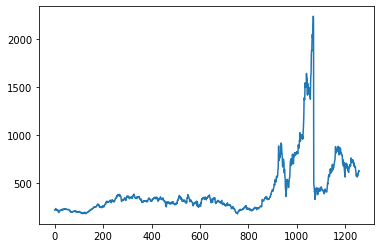

In [78]:
df.plot()

In [79]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [80]:
df.shape

(1258, 1)

In [81]:
training_size = int(len(df)*0.70)
testing_size = len(df)-training_size

In [82]:
train_data, test_data = df[0:training_size,:], df[training_size:len(df)]

In [83]:
def create_dataset(dataset, time_steps=1):
  X, y = [], []
  for i in range(len(dataset)-time_steps-1):
    a = dataset[i:(i+time_steps), 0]      # creating data from 0 to 100 as X or independent variable
    X.append(a)
    y.append(dataset[i + time_steps, 0]) # dependenet variable y
  return np.array(X), np.array(y)

In [84]:
X_train, y_train = create_dataset(train_data, 100)
X_test, y_test = create_dataset(test_data, 100)

In [85]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((779, 100), (779,), (277, 100), (277,))

In [86]:
X_train.shape[0], X_train.shape[1]

(779, 100)

In [87]:
# reshaping our data as per LSTM i.e [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [88]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [89]:
model = Sequential([
                    LSTM(64, return_sequences=True, input_shape=(100, 1)),
                    LSTM(64, return_sequences=True),
                    LSTM(64, return_sequences=True),
                    LSTM(64),
                    Dense(1)
])

In [90]:
model.compile(loss="mean_squared_error", optimizer="adam")

In [91]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100, 64)           16896     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100, 64)           33024     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 64)           33024     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
25/25 [==============================] - 13s 279ms/step - loss: 9.9378e-04 - val_loss: 0.0340
Epoch 2/100
25/25 [==============================] - 5s 203ms/step - loss: 2.2155e-04 - val_loss: 0.0286
Epoch 3/100
25/25 [==============================] - 5s 204ms/step - loss: 1.8246e-04 - val_loss: 0.0219
Epoch 4/100
25/25 [==============================] - 5s 202ms/step - loss: 1.5064e-04 - val_loss: 0.0208
Epoch 5/100
25/25 [==============================] - 5s 204ms/step - loss: 1.3380e-04 - val_loss: 0.0186
Epoch 6/100
25/25 [==============================] - 5s 202ms/step - loss: 1.2364e-04 - val_loss: 0.0180
Epoch 7/100
25/25 [==============================] - 5s 202ms/step - loss: 1.2413e-04 - val_loss: 0.0195
Epoch 8/100
25/25 [==============================] - 5s 201ms/step - loss: 1.1839e-04 - val_loss: 0.0172
Epoch 9/100
25/25 [==============================] - 5s 202ms/step - loss: 1.2096e-04 - val_loss: 0.0195
Epoch 10/100
25/25 [==============================] - 

In [93]:
train_predicted = model.predict(X_train)
test_predicted = model.predict(X_test)

In [94]:
train_predicted = scaler.inverse_transform(train_predicted)
test_predicted = scaler.inverse_transform(test_predicted)

In [95]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predicted))

298.33478257257286

In [96]:
math.sqrt(mean_squared_error(y_test, test_predicted))

753.208165203706

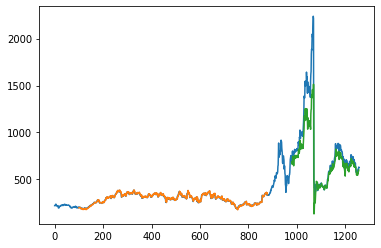

In [97]:
import numpy
look_back = 100
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(train_predicted)+look_back, :] = train_predicted
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predicted)+(look_back*2)+1:len(df)-1, :] = test_predicted
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [98]:
## blue line is original dataset
## orange line is train predicted dataset
## green line in test predicted dataset

In [99]:
len(test_data)

378

In [100]:
X_input = test_data[278:].reshape(1, -1)
X_input.shape

(1, 100)

In [101]:
temp_input = list(X_input)
temp_input = temp_input[0].tolist()

In [102]:
lst_output=[]
n_steps=100
i=0
while(i<30):
  if(len(temp_input)>100):
    #print(temp_input)
    x_input=np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input))
    x_input=x_input.reshape(1,-1)
    x_input = x_input.reshape((1, n_steps, 1))
    #print(x_input)
    yhat = model.predict(x_input, verbose=0)
    print("{} day output {}".format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input=temp_input[1:]
    print(temp_input)
    lst_output.extend(yhat.tolist())
    i=i+1
  else:
    X_input = X_input.reshape((1, n_steps,1))
    yhat = model.predict(X_input, verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i=i+1
    print(lst_output)


[0.2055042]
101
[[0.20550419390201569]]
1 day input [0.30929031 0.34035188 0.30693569 0.32550564 0.32791852 0.32335007
 0.31420346 0.3231316  0.32599598 0.32334521 0.32414627 0.34073056
 0.34184233 0.33265203 0.31870394 0.29836196 0.32083038 0.3368418
 0.32805445 0.32577266 0.32686015 0.33229277 0.32551535 0.30384313
 0.30716387 0.30932915 0.29966793 0.30060492 0.29537621 0.29242443
 0.25999379 0.25239103 0.27335444 0.24432221 0.24105972 0.26190176
 0.24637097 0.23023333 0.2148142  0.20341007 0.18644224 0.24012759
 0.23744769 0.25276    0.24991018 0.25680898 0.2417297  0.25383293
 0.23021391 0.23104409 0.23838954 0.23458331 0.21910107 0.22401422
 0.21348882 0.20988649 0.22169843 0.23738458 0.23438425 0.24860907
 0.2488858  0.23886046 0.24508928 0.24179767 0.25391547 0.28320986
 0.2686015  0.27181544 0.27226694 0.2600569  0.26217363 0.27437396
 0.26251347 0.26722757 0.27149987 0.25525542 0.25023546 0.24178796
 0.25753721 0.24562332 0.2401373  0.2388459  0.23525328 0.23954015
 0.21850392

In [103]:
day_new = np.arange(1, 101)
day_predict = np.arange(101, 131)

In [104]:
import matplotlib.pyplot as plt

In [105]:
len(df)

1258

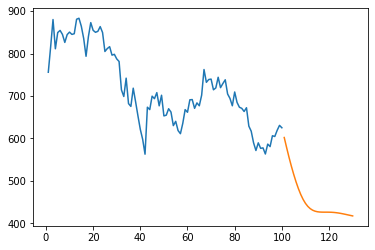

In [106]:
plt.plot(day_new, scaler.inverse_transform(df[1158:])) ## taking last 100 days data
plt.plot(day_predict, scaler.inverse_transform(lst_output)) ## plotting next 30 days predicted output which is stored in lst_output

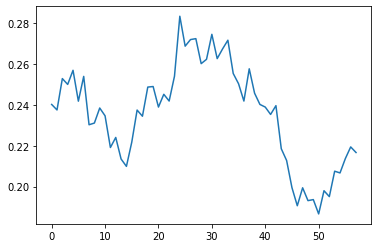

In [107]:
plt.plot(df[1200:])

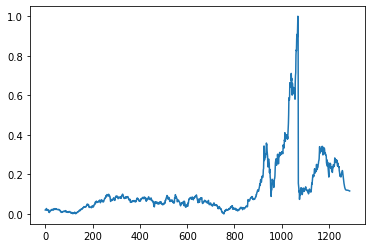

In [108]:
df1 = df.tolist()
df1.extend(lst_output)
plt.plot(df1)

In [114]:
lst_output.shape

AttributeError: ignored

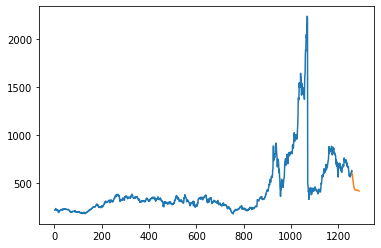

In [116]:
plt.plot(np.arange(1, 1259), scaler.inverse_transform(df))
plt.plot(np.arange(1259, 1289,), scaler.inverse_transform(lst_output))

In [117]:
## blue line is original data
## orange line predicts share price for next 30 days